In [1]:
from map_generator import MapGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from Planners.abc.abc_problem import ABCProblem
from Planners.pso.pso_problem import PSOProblem
from Planners.gwo.gwo_problem import GWOProblem
#from Planners.a_star.a_star import AStarPlanner
from Planners.util.planner_base import PlannerBase
from Planners.helper import linear_interpolation
from IPython.display import display, clear_output

In [2]:
class AStarPlanner:
    class Node:
        def __init__(self, x_pos, y_pos, goal_node):
            self.x_pos, self.y_pos = x_pos, y_pos
            if goal_node is None:
                goal_node = self
            self.goal_node = goal_node
            self.parent = None
            self.distance = 0
            goal_distance = (x_pos - goal_node.x_pos) ** 2
            goal_distance += (y_pos - goal_node.y_pos) ** 2
            goal_distance = goal_distance ** 0.5
            self.goal_distance = goal_distance
            self.cost = goal_distance
        
        def set_parent(self, parent):
            self.parent = parent
            if self.x_pos == parent.x_pos or self.y_pos == parent.y_pos:
                step_length = 1
            else:
                step_length = 2 ** 0.5
            self.distance = parent.distance + step_length
            self.cost = self.distance + self.goal_distance
        
        def is_goal(self):
            return self.x_pos == self.goal_node.x_pos and self.y_pos == self.goal_node.y_pos

    def __init__(self, curr_map):
        self.map = curr_map
        self.y_min, self.x_min = 0, 0
        self.y_max, self.x_max = curr_map.shape
        self.visited = np.zeros(curr_map.shape, dtype=bool)
    
    def verifyNode(self, node):
        if node.x_pos < self.x_min:
            return False
        if node.x_pos >= self.x_max:
            return False
        if node.y_pos < self.y_min:
            return False
        if node.y_pos >= self.y_max:
            return False
        if self.map[node.y_pos, node.x_pos] == 0:
            return False
        return True
    
    def get_id(self, node):
        return node.y_pos * self.x_max + node.x_pos
    
    def get_neighbours(self, curr_node, goal_node):
        neighbour_nodes = list()
        for x_move in [-1, 0, 1]:
            for y_move in [-1, 0, 1]:
                if x_move == 0 and y_move == 0:
                    continue
                new_node = self.Node(curr_node.x_pos+x_move, curr_node.y_pos+y_move, goal_node)
                new_node.set_parent(curr_node)
                if self.verifyNode(new_node):
                    neighbour_nodes.append(new_node)
        return neighbour_nodes
    
    def get_path(self, start, end):
        goal_node = self.Node(end[0], end[1], None)
        start_node = self.Node(start[0], start[1], goal_node)
        goal_found = False
        
        if not self.verifyNode(start_node) or not self.verifyNode(goal_node):
            return -1
        
        curr_node = start_node
        frontier = dict()
        for node in self.get_neighbours(curr_node, goal_node):
            node_id = self.get_id(node)
            frontier[node_id] = node
        
        while len(frontier):
            curr_node_key = min(frontier, key=lambda node_id: frontier[node_id].cost)
            curr_node = frontier[curr_node_key]
            
            if curr_node.is_goal():
                goal_node.set_parent(curr_node.parent)
                goal_found = True
                break
            
            del frontier[curr_node_key]
            self.visited[curr_node.y_pos, curr_node.x_pos] = True
            
            for node in self.get_neighbours(curr_node, goal_node):
                node_id = self.get_id(node)
                if self.visited[node.y_pos, node.x_pos]:
                    continue
                if node_id not in frontier:
                    frontier[node_id] = node
                else:
                    if frontier[node_id].cost > node.cost:
                        frontier[node_id] = node
        
        if not goal_found:
            print('Path to goal does not exists')
            return np.array([])
        
        path_points = list()
        curr_node = goal_node
        while curr_node.x_pos != start_node.x_pos or curr_node.y_pos !=start_node.y_pos:
            path_points.append([curr_node.x_pos, curr_node.y_pos])
            curr_node = curr_node.parent
        path_points.append([start_node.x_pos, start_node.y_pos])  # add start point
        
        return np.array(path_points)

In [3]:
def get_path_cost(curr_map, path):
    length = 0
    violations = 0
    violation_cost = 0
    prev_x, prev_y = path[0]
    prev_cost = curr_map[prev_y, prev_x]
    root_2 = 2 ** 0.5
    for curr_x, curr_y in path[1:]:
        if curr_x == prev_x or curr_y == prev_y:
            length += 1
        else:
            length += root_2
        curr_cost = curr_map[curr_y, curr_x]
        if curr_cost == 0:
            violation_cost += 1
            if curr_cost != prev_cost:
                violations += 1
        prev_cost = curr_cost
    return length, violations, violation_cost

In [4]:
class ParticleWarehouse:
    def __init__(self, parent_dir):
        if not os.path.exists(parent_dir):
            os.mkdir(parent_dir)
        self.parent_dir = parent_dir
    
    def get_callback(self, curr_map, curr_planner, run):
        store_dir = os.path.join(self.parent_dir, curr_map)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        store_dir = os.path.join(store_dir, curr_planner)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        store_dir = os.path.join(store_dir, 'run_%d' % run)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        def curr_callback(iteration, particle):
            file_name = os.path.join(store_dir, 'particle_%d.txt' % iteration)
            np.savetxt(file_name, particle)
            print('Completed iteration', iteration+1)
        return curr_callback
    
    def save_result(self, file_name, data_df):
        file_path = os.path.join(self.parent_dir, file_name)
        data_df.to_csv(file_path, index=False)

In [5]:
planner_params = {
    'AStar Planner': {
        'optimizer_params': {}
    },
    'ABC Optimizer': {
        'optimizer': ABCProblem,
        'optimizer_params': {
            'iteration_number': 20,
            'bees': 10,
            'high_step_prob': 0.3
        },
        'cost_func_wt': (2, 1)
    },
    'GWO Optimizer': {
        'optimizer': GWOProblem,
        'optimizer_params': {
            'iteration_number': 20,
            'wolves': 20
        },
        'cost_func_wt': (2, 1)
    },
    'PSO Optimizer': {
        'optimizer': PSOProblem,
        'optimizer_params': {
            'iteration_number': 20,
            'particles': 20,
            'weight': 0.5,
            'c_1': 1.5,
            'c_2': 1.5
        },
        'cost_func_wt': (2, 1)
    }
}

In [6]:
map_details = {
    'map1': {
        'file_name': 'custom_map_2_params.yaml',
        'start': [100, 400],
        'end': [400, 100],
        'points': 1
    },
    'map2': {
        'file_name': 'custom_map_4_params.yaml',
        'start': [50, 250],
        'end': [250, 250],
        'points': 2
    },
    'map3': {
        'file_name': 'custom_map_3_params.yaml',
        'start': [50, 450],
        'end': [300, 100],
        'points': 2
    },
    'map4': {
        'file_name': 'custom_map_1_params.yaml',
        'start': [600, 800],
        'end': [1700, 500],
        'points': 3
    },
    'map5': {
        'file_name': 'map_012_params.yaml',
        'start': [250, 1750],
        'end': [1100, 200],
        'points': 4
    }
}

In [7]:
results = pd.DataFrame({
    'map_file':pd.Series(dtype='str'),
    'planner_name': pd.Series(dtype='str'),
    'run': pd.Series(dtype='int'),
    'time_taken': pd.Series(dtype='float'),
    'distance': pd.Series(dtype='float'),
    'violation': pd.Series(dtype='float'),
    'violation_cost': pd.Series(dtype='float')
})
store_dir = os.path.join('results', 'testing_5')
total_runs = 5
warehouse = ParticleWarehouse(store_dir)

map1-AStar Planner-1


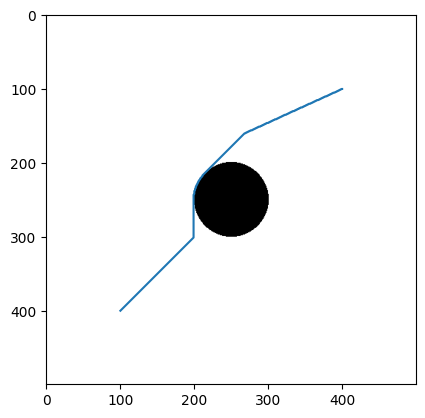

map1-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


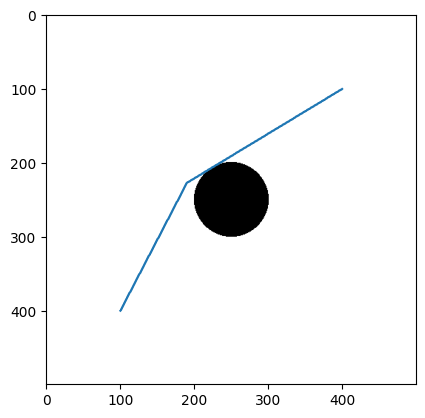

map1-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


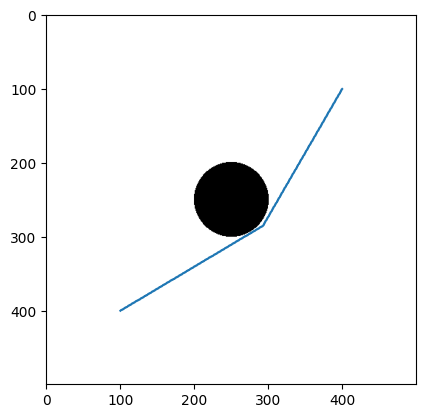

map1-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


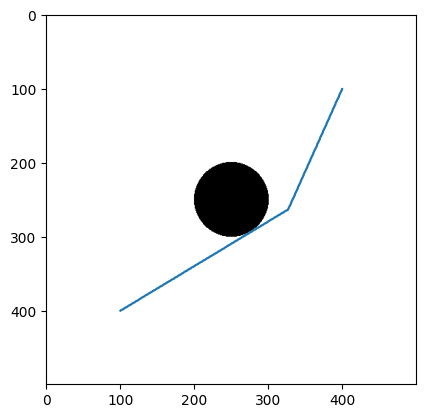

map1-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


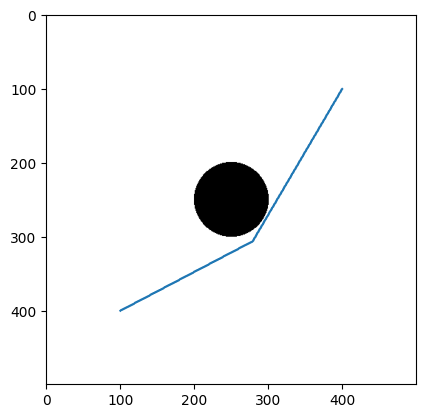

map1-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


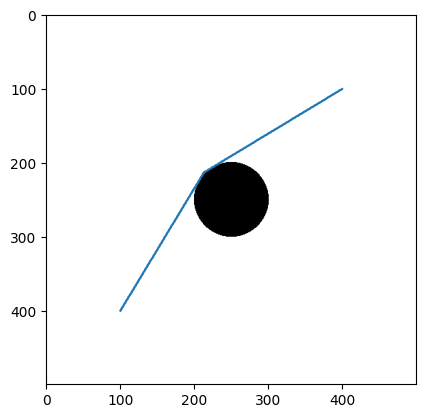

map1-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


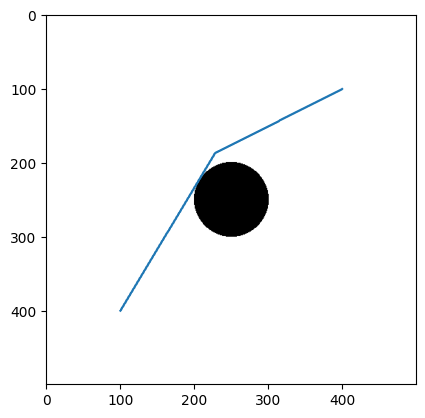

map1-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


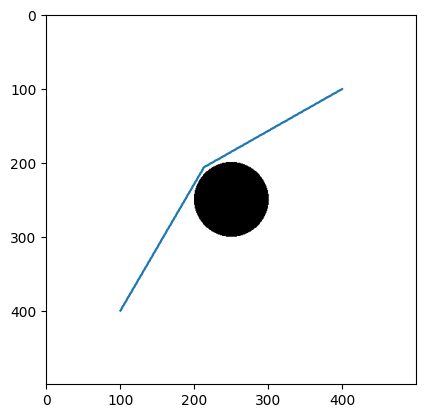

map1-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


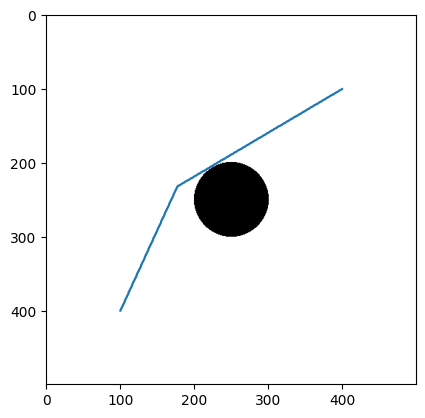

map1-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


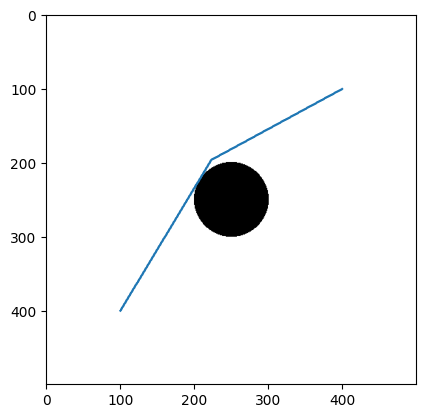

map1-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


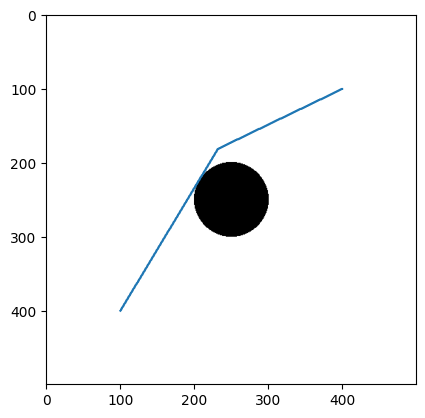

map1-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


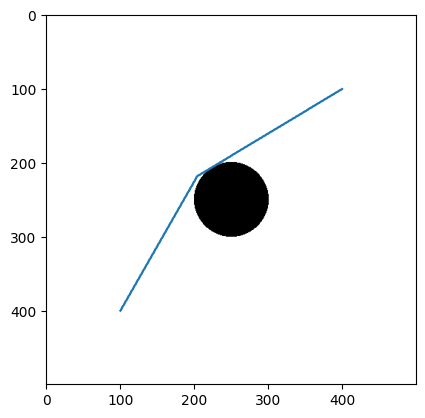

map1-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


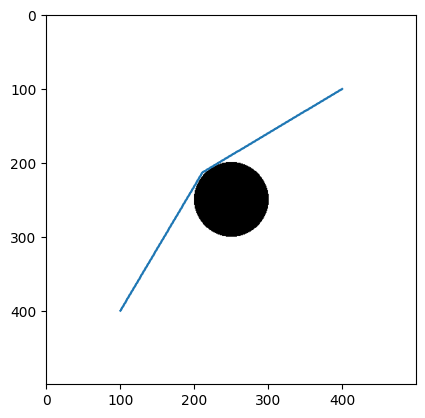

map1-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


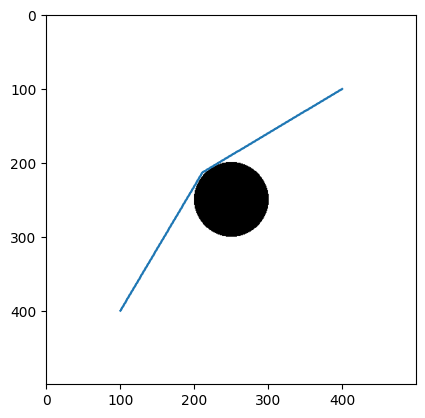

map1-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


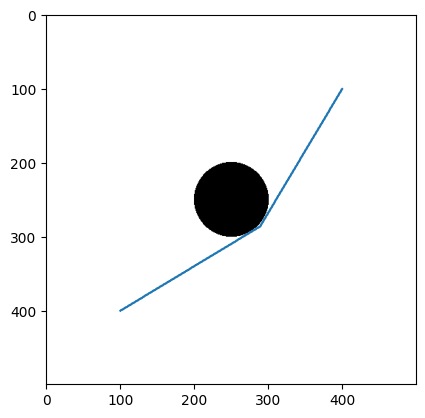

map1-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


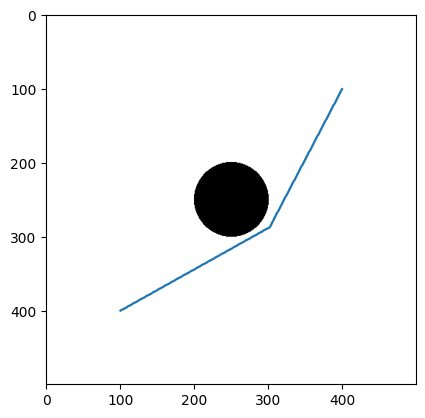

map2-AStar Planner-1


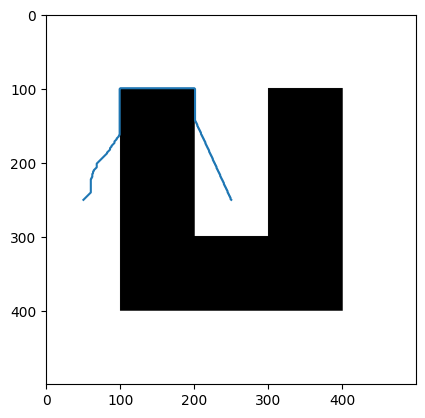

map2-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


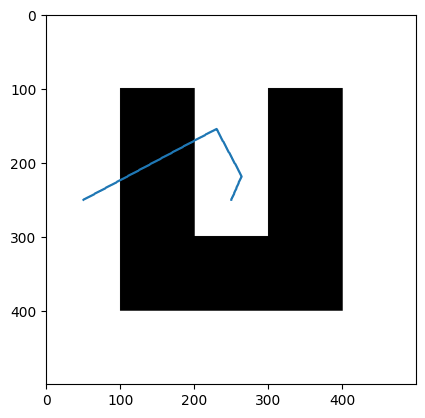

map2-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


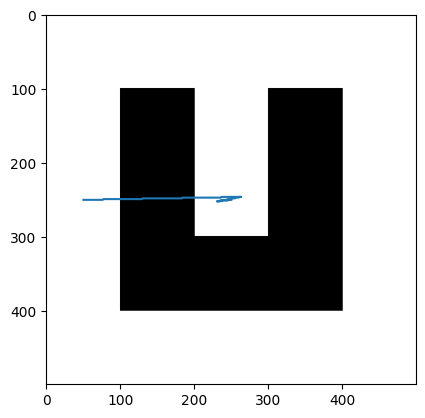

map2-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


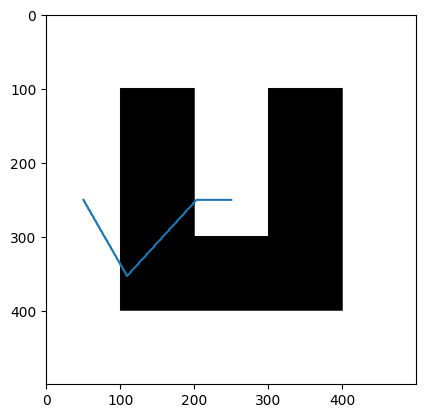

map2-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


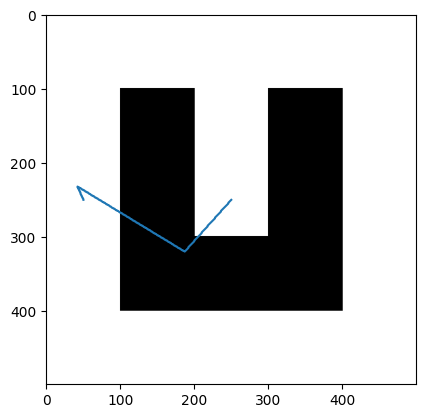

map2-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


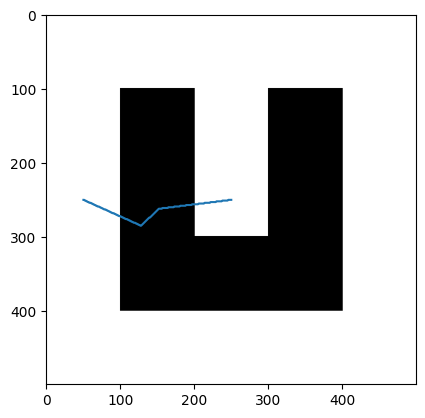

map2-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


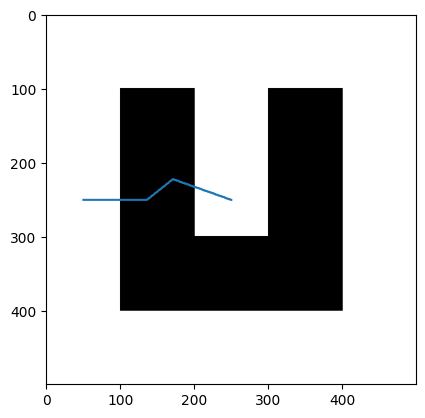

map2-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


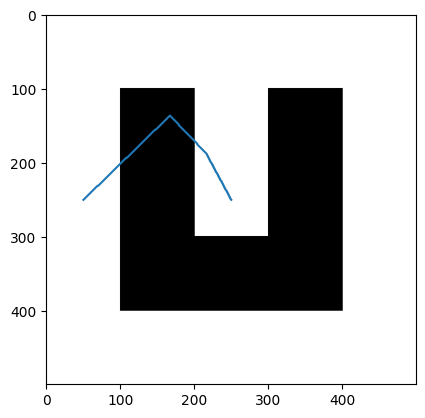

map2-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


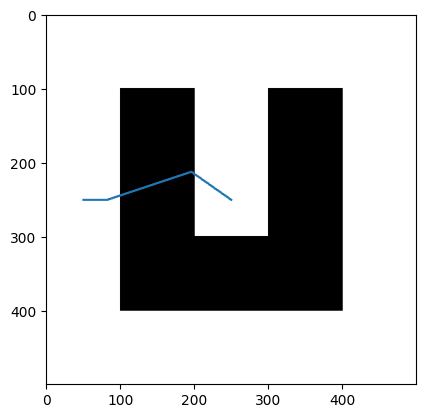

map2-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


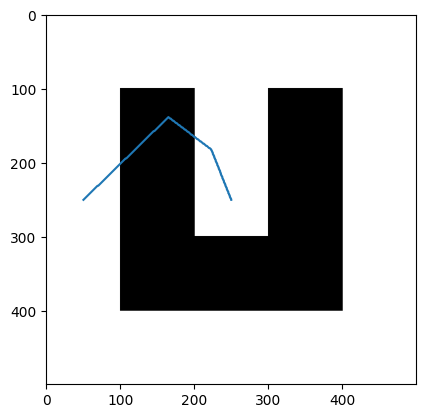

map2-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


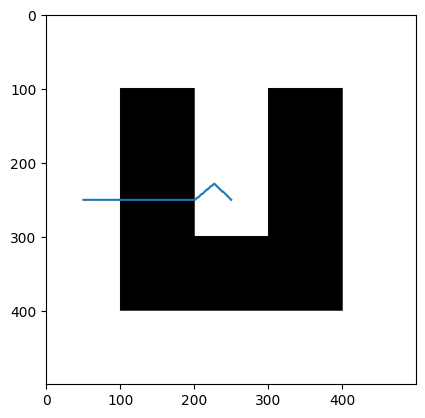

map2-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


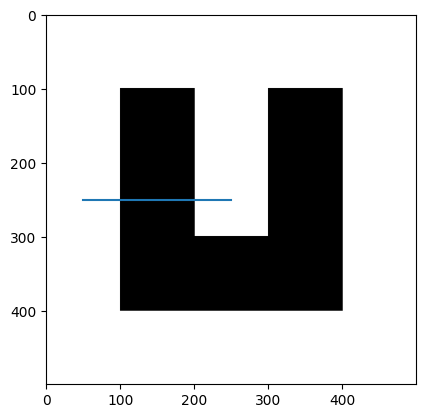

map2-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


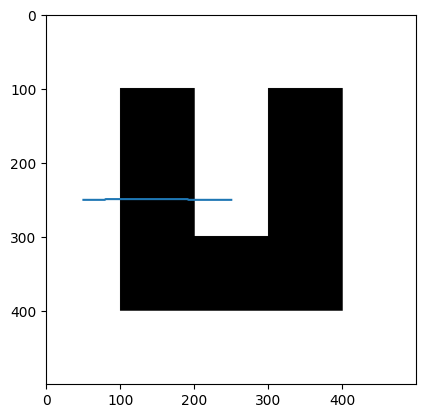

map2-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


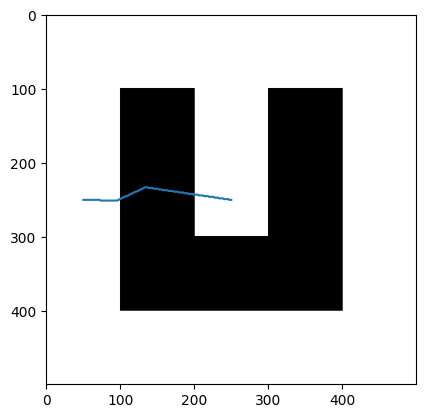

map2-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


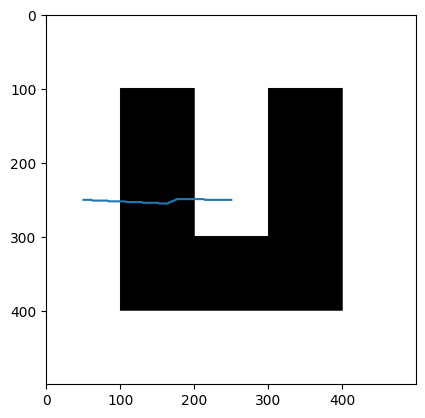

map2-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


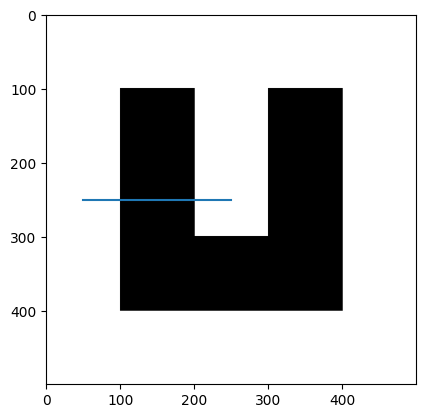

map3-AStar Planner-1


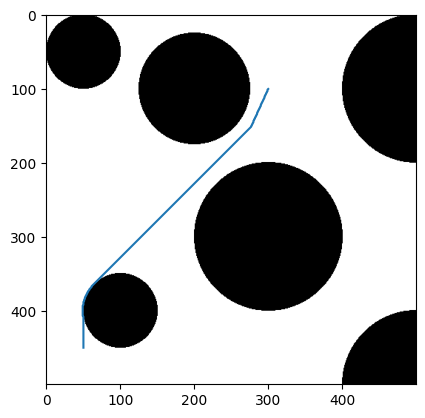

map3-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


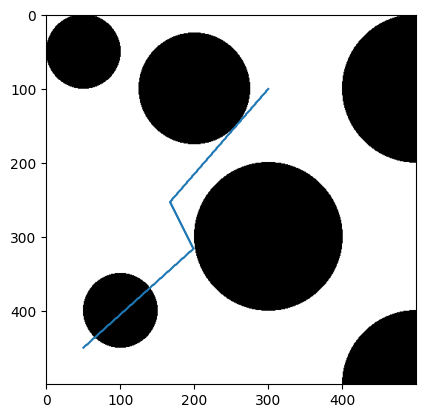

map3-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


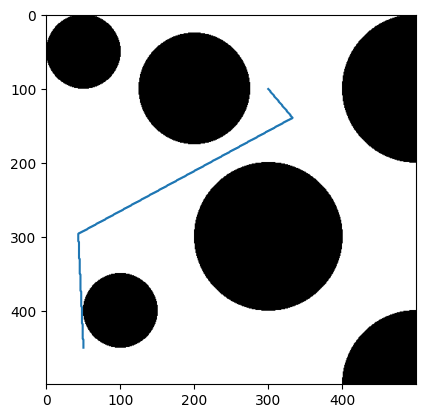

map3-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


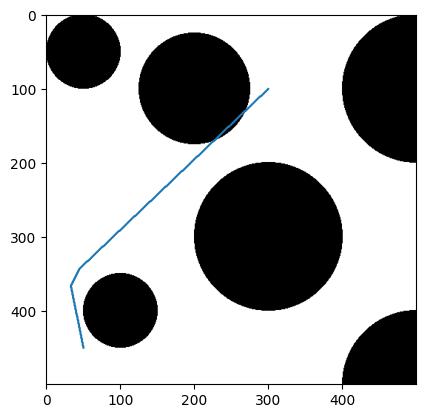

map3-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


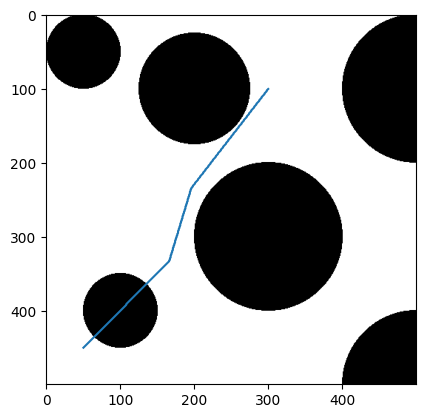

map3-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


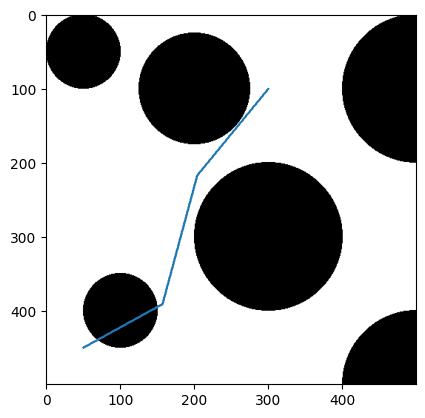

map3-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


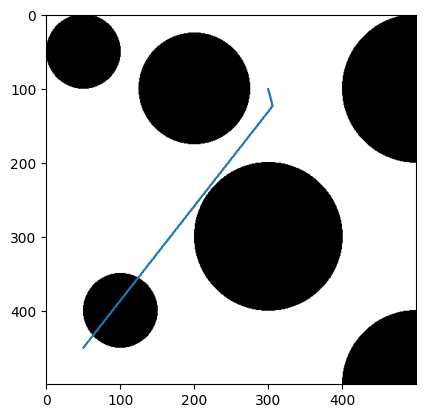

map3-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


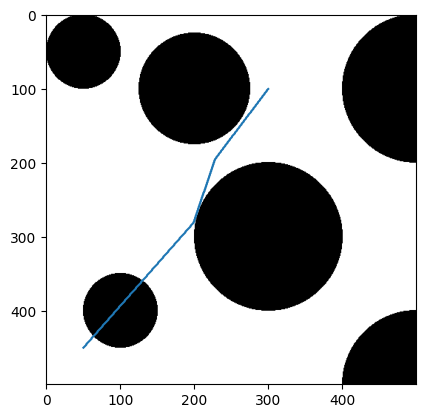

map3-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


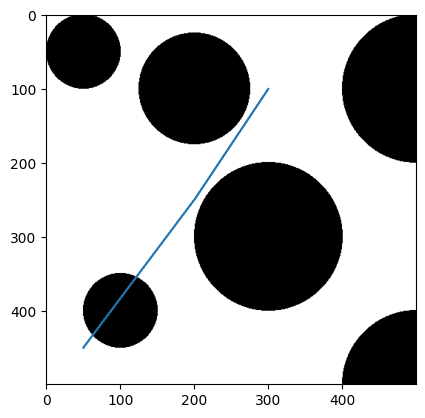

map3-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


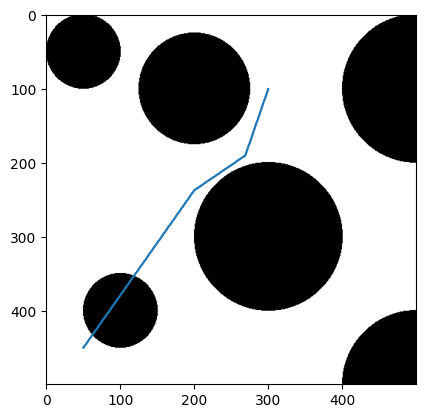

map3-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


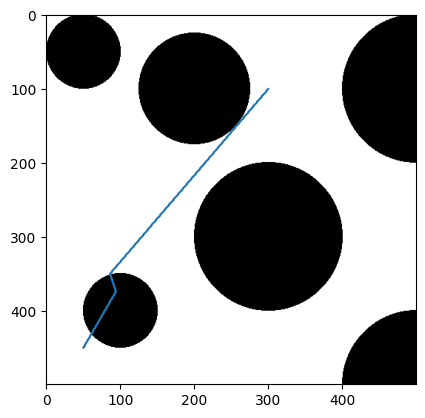

map3-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


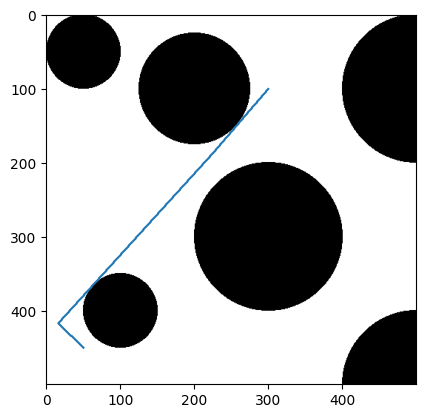

map3-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


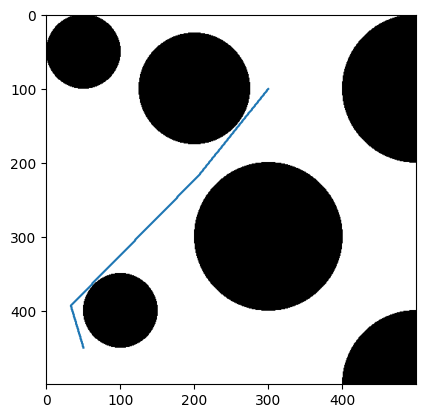

map3-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


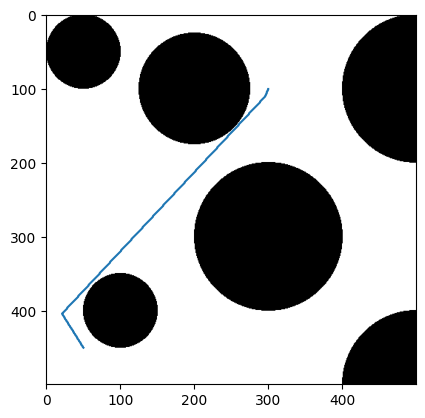

map3-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


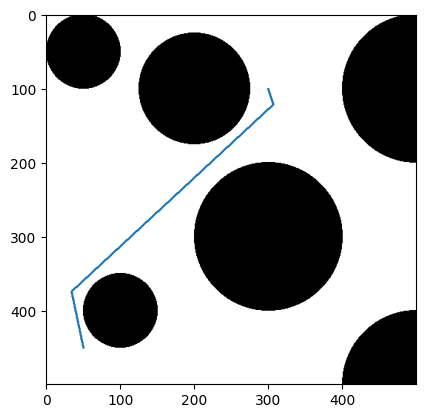

map3-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


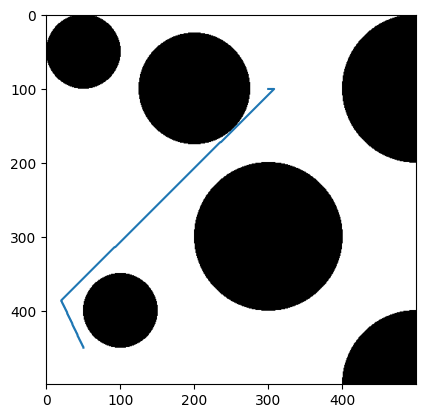

map4-AStar Planner-1


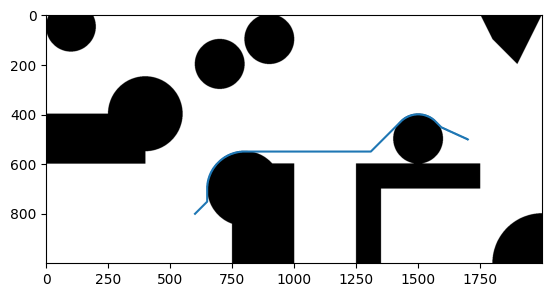

map4-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


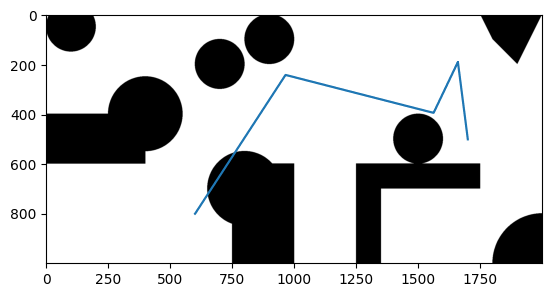

map4-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


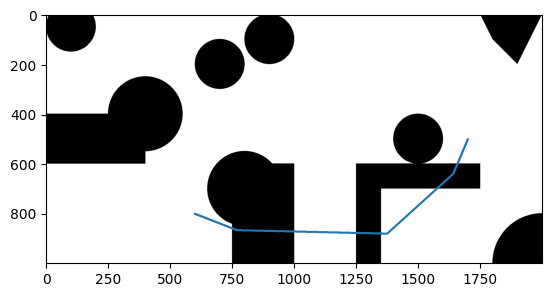

map4-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


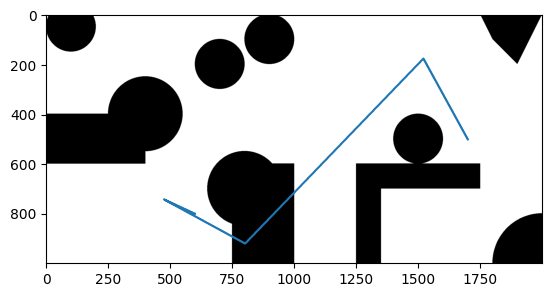

map4-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


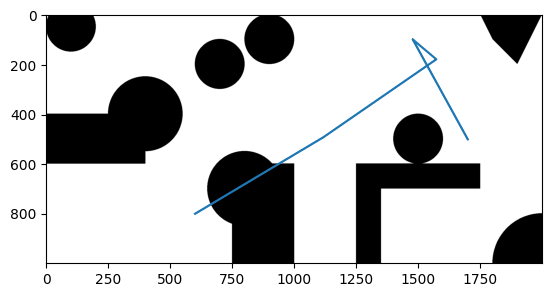

map4-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


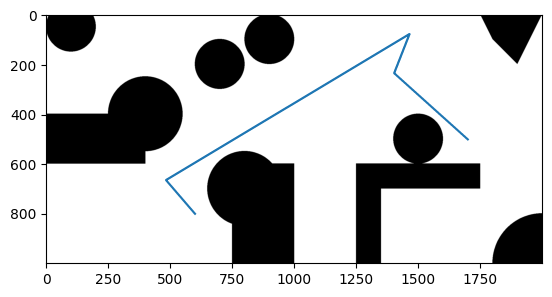

map4-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


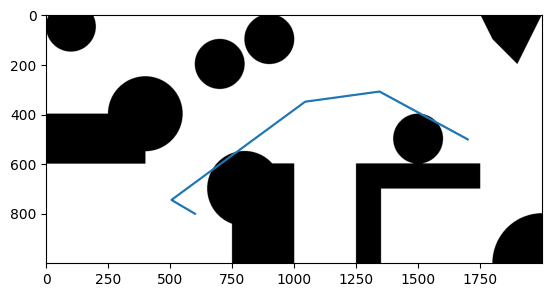

map4-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


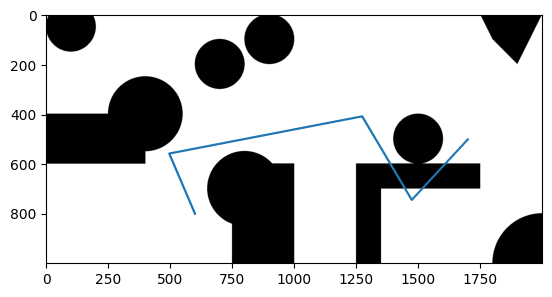

map4-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


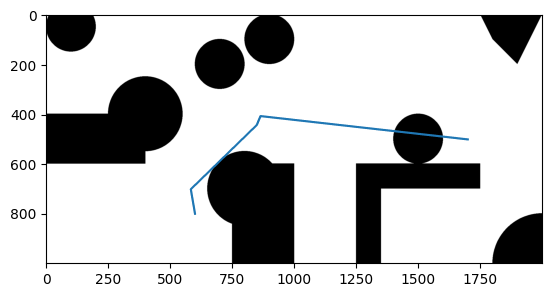

map4-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


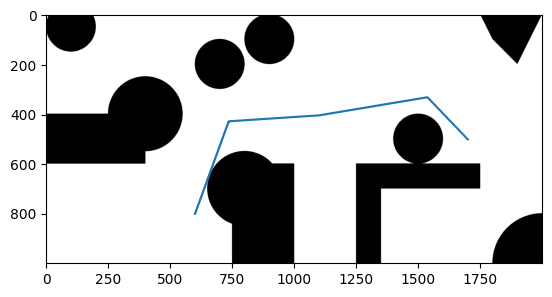

map4-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


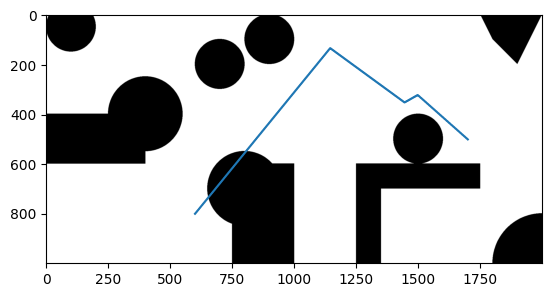

map4-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


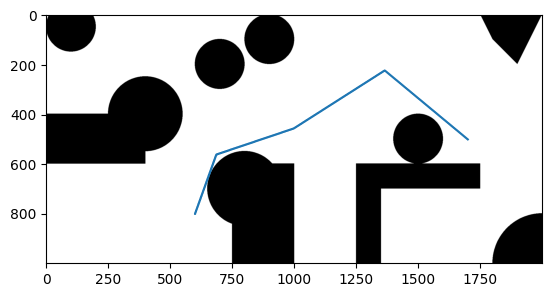

map4-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


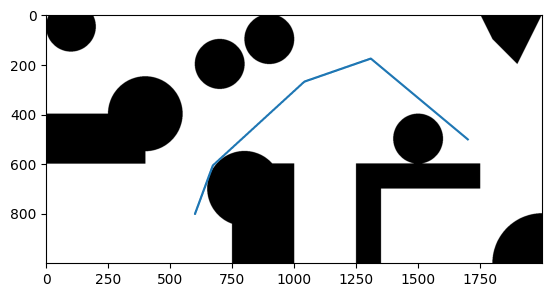

map4-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


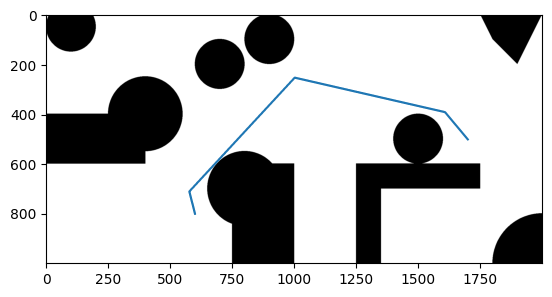

map4-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


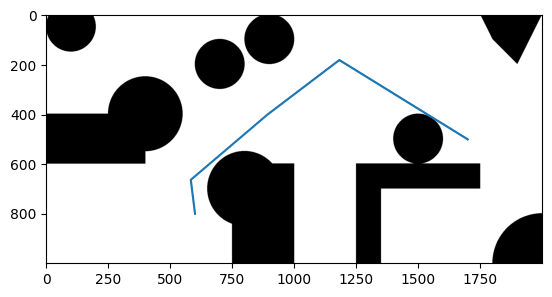

map4-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


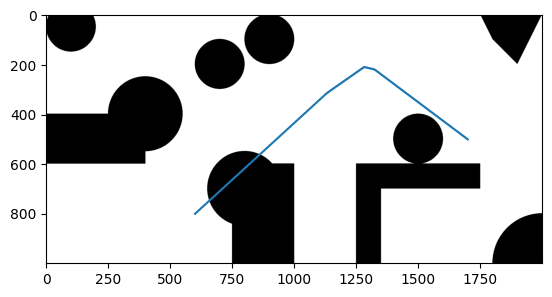

map5-AStar Planner-1


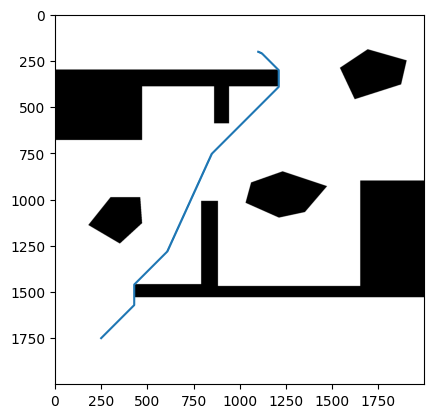

map5-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


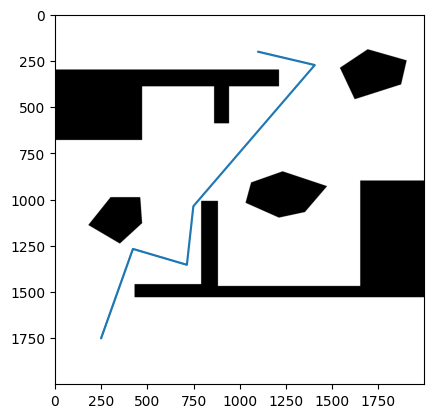

map5-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


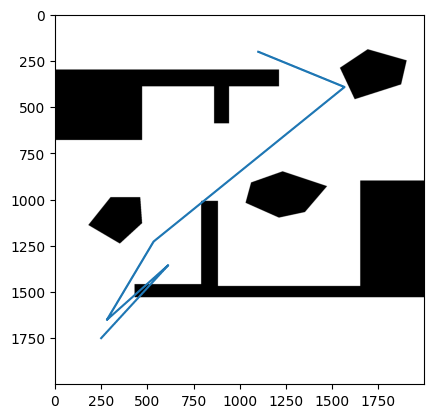

map5-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


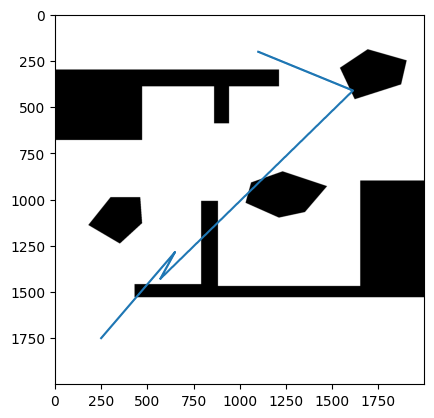

map5-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


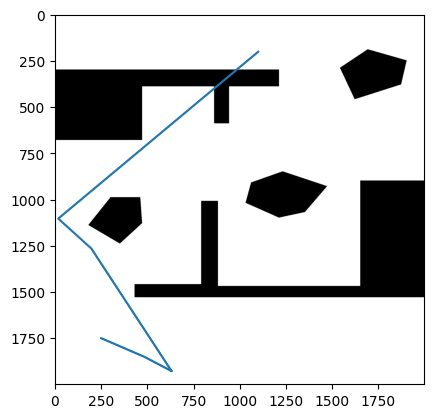

map5-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


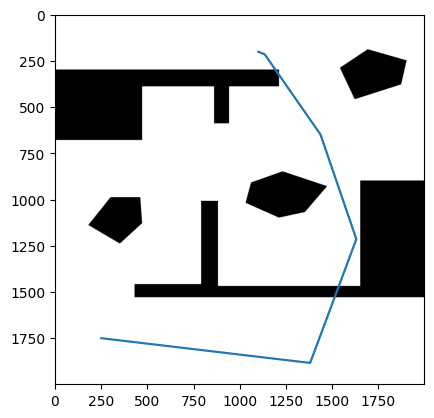

map5-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


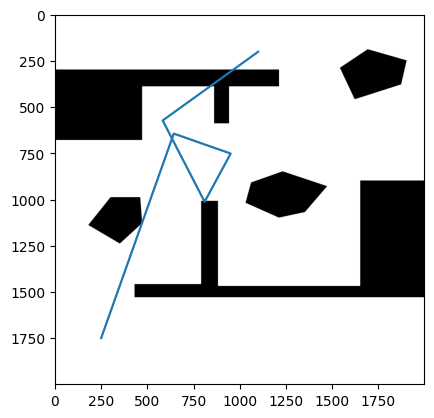

map5-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


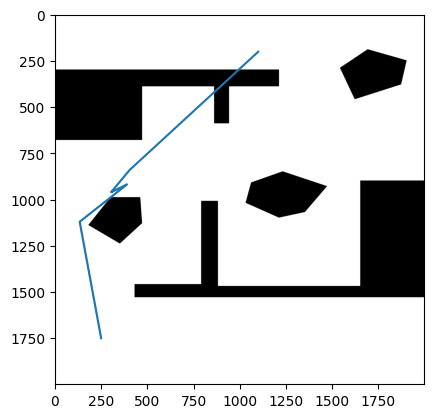

map5-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


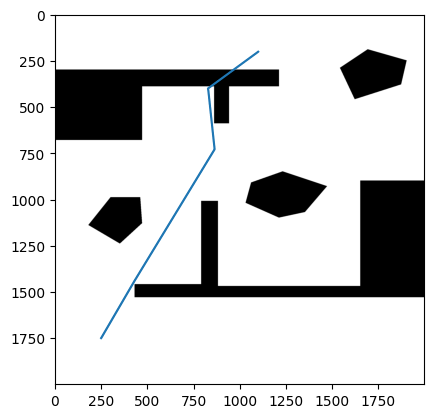

map5-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


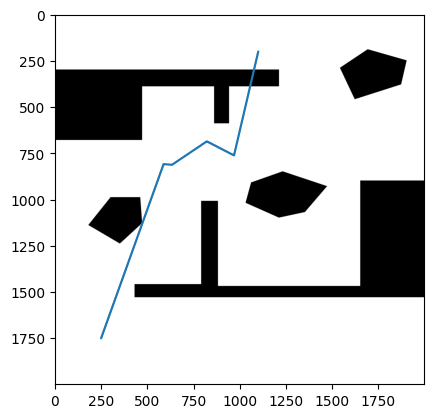

map5-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


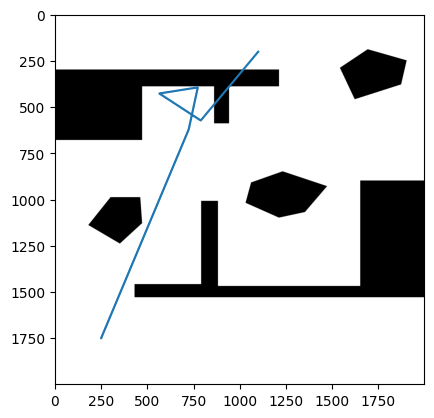

map5-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


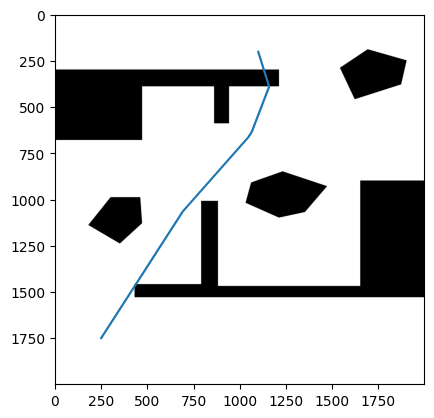

map5-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


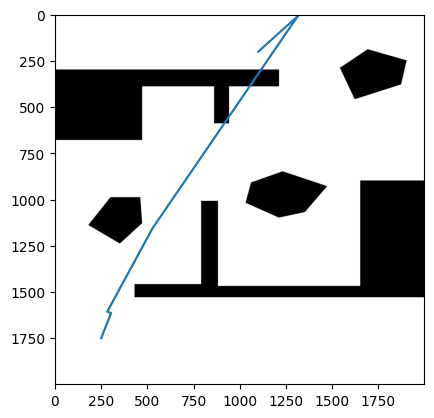

map5-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


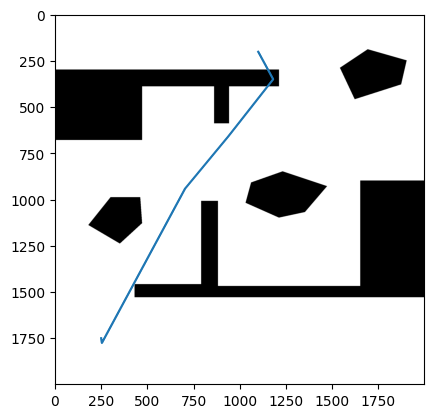

map5-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


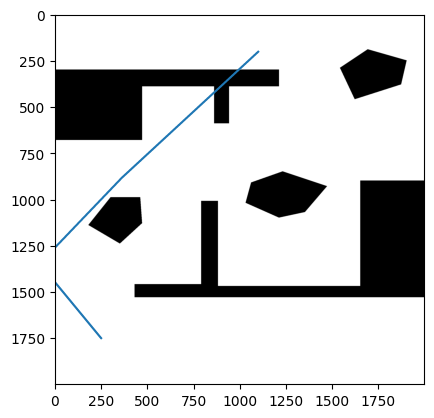

map5-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20


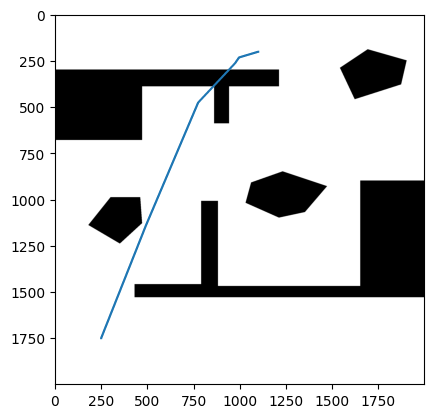

In [8]:
for map_name in map_details.keys():
    curr_details = map_details[map_name]
    
    file_name = curr_details['file_name']
    map_file_name = file_name.split('.')[0]
    map_gen = MapGenerator(os.path.join('map_params', file_name))
    curr_map = map_gen.map.get_map()
    
    start = np.array(curr_details['start']).astype(np.int32)
    end = np.array(curr_details['end']).astype(np.int32)
    
    for planner_name in planner_params.keys():
        curr_params = planner_params[planner_name]
        curr_params['map'] = curr_map
        
        opt_params = curr_params['optimizer_params']
        opt_params['points'] = curr_details['points']
        
        for i in range(total_runs):
            run = i + 1
            print(map_name, planner_name, run, sep='-')
            opt_params['iteration_callback'] = warehouse.get_callback(map_file_name, planner_name, run)
            if planner_name == 'AStar Planner':
                break
                planner = AStarPlanner(curr_map)
            else:
                planner = PlannerBase(**curr_params)
            start_time = time.time()
            path = planner.get_path(start, end)
            end_time = time.time()
            elapsed_time = end_time - start_time
            path_length, violations, violation_cost = get_path_cost(curr_map, path)
            results.loc[len(results)] = [map_file_name, planner_name, run, elapsed_time, path_length, violations, violation_cost]
            plt.imshow(curr_map, cmap='gray')
            plt.plot(path[:, 0], path[:, 1])
            plt.show()
            if planner_name == 'AStar Planner':
                break

In [9]:
unique_maps = results['map_file'].unique()
unique_planners = results['planner_name'].unique()
for map_name in unique_maps:
    print('Current Map:', map_name)
    save_results = pd.DataFrame({
        'planner_name': pd.Series(dtype='str'),
        'avg_time': pd.Series(dtype='float'),
        'avg_distance': pd.Series(dtype='float'),
        'avg_violation': pd.Series(dtype='float'),
        'avg_violation_cost': pd.Series(dtype='float')
    })
    curr_map_df = results[results['map_file'] == map_name]
    for planner_name in unique_planners:
        curr_df = curr_map_df[curr_map_df['planner_name'] == planner_name]
        avg_time = np.mean(curr_df['time_taken'])
        avg_distance = np.mean(curr_df['distance'])
        avg_violation = np.mean(curr_df['violation'])
        avg_violation_cost  = np.mean(curr_df['violation_cost'])
        save_results.loc[len(save_results)] = [planner_name, avg_time, avg_distance, avg_violation, avg_violation_cost]
    warehouse.save_result(map_name+'.csv', save_results)
    print(save_results)
    print('')

Current Map: custom_map_2_params
    planner_name   avg_time  avg_distance  avg_violation  avg_violation_cost
0  AStar Planner  24.571350    525.673232            0.0                 0.0
1  ABC Optimizer   2.529032    540.229581            0.0                 0.0
2  GWO Optimizer   1.597877    544.389379            0.0                 0.0
3  PSO Optimizer   1.490369    535.704097            0.0                 0.0

Current Map: custom_map_4_params
    planner_name   avg_time  avg_distance  avg_violation  avg_violation_cost
0  AStar Planner  13.488213    568.099639            0.0                 0.0
1  ABC Optimizer   3.221312    338.729422            1.0               105.6
2  GWO Optimizer   1.350288    280.342799            1.0               101.2
3  PSO Optimizer   1.334947    235.953737            1.0               101.0

Current Map: custom_map_3_params
    planner_name  avg_time  avg_distance  avg_violation  avg_violation_cost
0  AStar Planner  6.417999    494.974747            0